In [1]:
import tarfile
tar_path = 'data/'
person_video_path = 'Vid_D_person'
extract_to = 'data'

with tarfile.open(tar_path+person_video_path+'.tar.xz') as f:
    f.extractall(extract_to)

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
from train import *
from networks import *
from functions import *
from imageloader import *

## Load Cropped Frames

In [3]:
image_folder = tar_path + person_video_path
frames_cropped, height_cropped, width_cropped = get_cropped_frames(image_folder)

## Load image

In [4]:
tar_path = 'data/'
person_video_path = 'Vid_D_person'
img_name = 'img0002.jpg'
img_path = tar_path + person_video_path + '/' + img_name
start_point = (136, 55)
end_point = (179, 187)
padding = 35

In [5]:
img, flatten_labels, foreground, background, marked_img = load_image_rect_flatten_labels(img_path, start_point, end_point, padding, thickness=2)

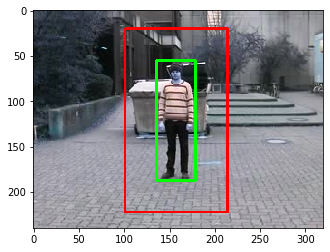

In [6]:
plt.imshow(marked_img)
plt.show()

## Model training

In [7]:
model_path = 'person_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [48]:
import torch.optim as optim
import numpy as np

last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [49]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = .4
print("margin:", margin)
criterion = TripletLoss(margin)
n_epochs = 9

margin: 0.4


In [50]:
model = train_model(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=95, num_batches=95, get_min_loss=False)

Epochs:  11%|█         | 1/9 [01:18<10:25, 78.22s/it]

loss: 0.552040


Epochs:  22%|██▏       | 2/9 [02:36<09:07, 78.27s/it]

loss: 0.372155


Epochs:  33%|███▎      | 3/9 [03:54<07:49, 78.26s/it]

loss: 0.240596


Epochs:  44%|████▍     | 4/9 [05:12<06:31, 78.20s/it]

loss: 0.189443


Epochs:  56%|█████▌    | 5/9 [06:30<05:12, 78.15s/it]

loss: 0.140805


Epochs:  67%|██████▋   | 6/9 [07:48<03:54, 78.08s/it]

loss: 0.115728


Epochs:  78%|███████▊  | 7/9 [09:03<02:33, 76.93s/it]

loss: 0.096729


Epochs:  89%|████████▉ | 8/9 [10:21<01:17, 77.29s/it]

loss: 0.092380


Epochs: 100%|██████████| 9/9 [11:39<00:00, 77.77s/it]

loss: 0.069804
Best val loss: 0.069804


In [51]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 64)
flatten_labels.shape: torch.Size([22826])
zeros count: 7853
not zeros count: 14973


correct: 21558, wrong: 1268, accuracy: 94.4449312187856%


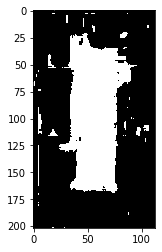

tensor([  0,   3,   3,  ..., 189, 201, 201])
tensor([ 3990,  3991,  3992,  ..., 18833, 18834, 18835])


In [52]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [53]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

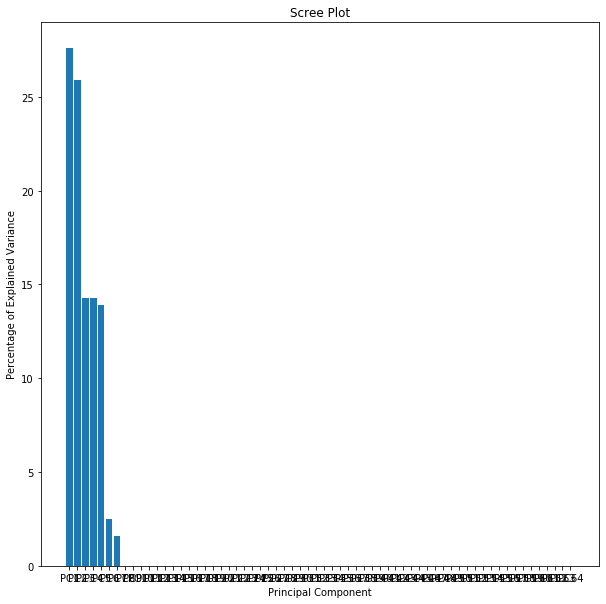

embedding26   -0.657323
embedding22   -0.656990
embedding62    0.238146
dtype: float64


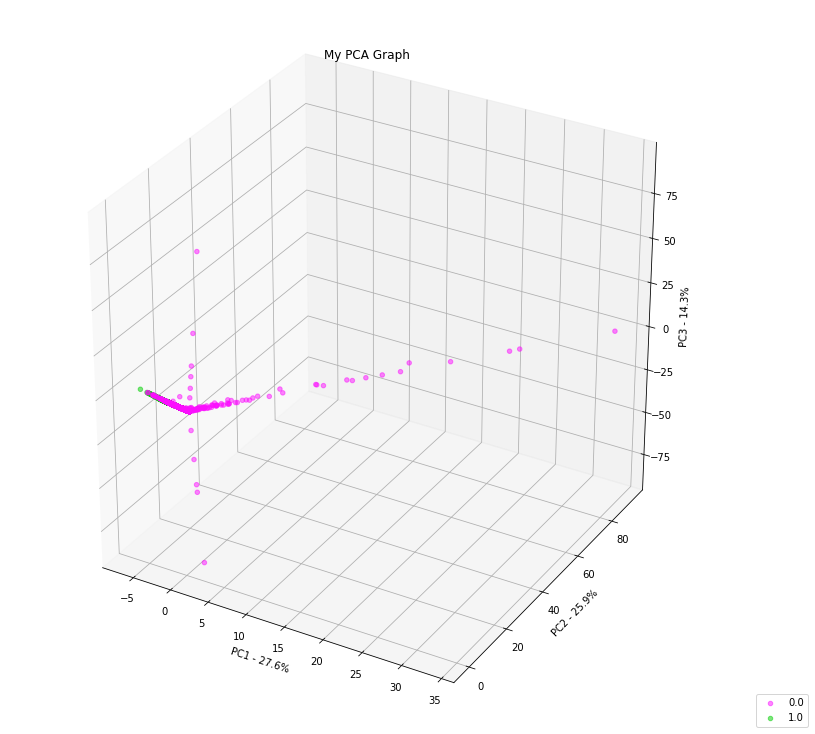

In [54]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [55]:
model_path = 'person_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [56]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 64)
flatten_labels.shape: torch.Size([22826])
zeros count: 7853
not zeros count: 14973


correct: 21558, wrong: 1268, accuracy: 94.4449312187856%


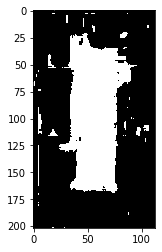

In [57]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [58]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [7]:
model_path = 'person_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [8]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [9]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [10]:
video_path = 'Videos/10fps_cropped_real_'+model_path+'.avi'
frames_step = 3

In [12]:
real_heat_maps = easy_create_real_video(model, centroids, frames_cropped, video_path, width_cropped,
                                        height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Time Elapsed (get_heatmaps func) 1m 14s


<Figure size 432x288 with 0 Axes>

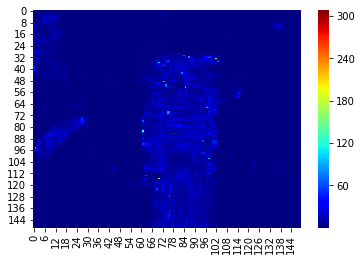

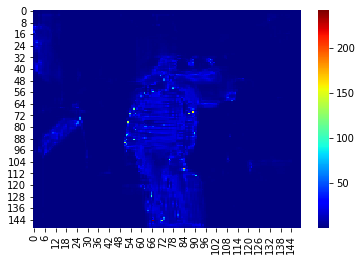

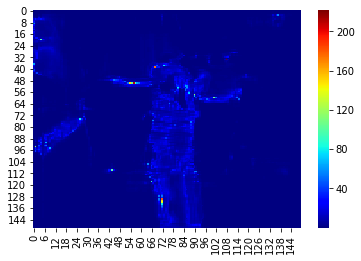

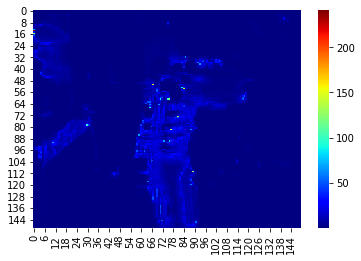

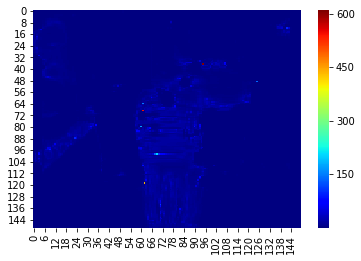

In [13]:
# print((width, height))
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()

## Model Training With MiniBatches

In [7]:
model_path = 'person_model9_1_5_minibatch'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [8]:
import torch.optim as optim
import numpy as np

last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [9]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
margin = .4
print("margin:", margin)
criterion = TripletLossMiniBatch(margin)
n_epochs = 9

margin: 0.4


In [10]:
model = train_model_with_mini_batch(model, criterion, img, flatten_labels, optimizer, foreground, background, num_epochs=n_epochs, batch_size=64, num_batches=10, get_min_loss=False)

Epochs:   0%|          | 0/9 [00:00<?, ?it/s]


tensor(1.2070)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [51]:
out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)

c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 64)
flatten_labels.shape: torch.Size([22826])
zeros count: 7853
not zeros count: 14973


correct: 21558, wrong: 1268, accuracy: 94.4449312187856%


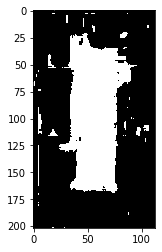

tensor([  0,   3,   3,  ..., 189, 201, 201])
tensor([ 3990,  3991,  3992,  ..., 18833, 18834, 18835])


In [52]:
centroids = get_centroids(embeddings, foreground, background)
# print("centroids:", centroids)
labels_shape = img.shape[-2], img.shape[-1]
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels_shape, centroids, num_classes=2)
# t = .view(-1)
t = torch.tensor(heat_map)
foreground2 = torch.where(t == 1)[0]
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()
print(foreground2)
print(foreground)

In [53]:
torch.save(model.state_dict(), 'Models/'+model_path+'.pt')

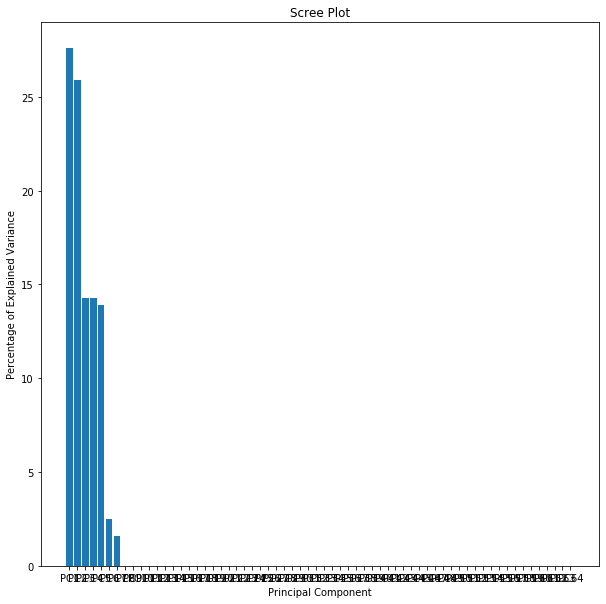

embedding26   -0.657323
embedding22   -0.656990
embedding62    0.238146
dtype: float64


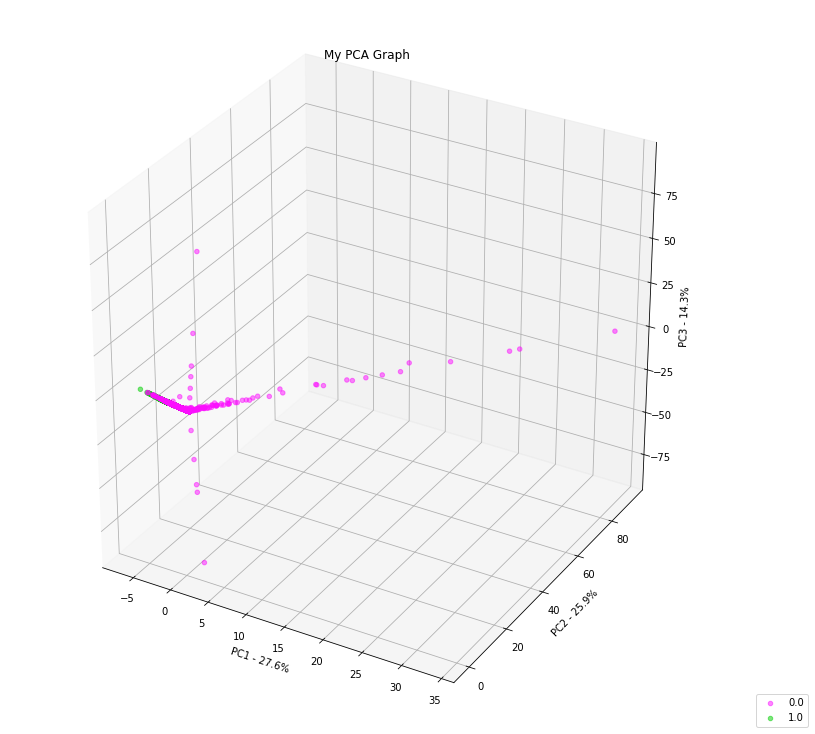

In [54]:
plot_PCA(embeddings, flatten_labels, out_features_size=out_features_size,classes= [0., 1.], colors=['#fc0fff', '#00cf00'], is_3D=True, draw_PCA_per_varc=True, figure_size=(10,10), top_range_loadingfactors=(0, 3))

### save Centroids

In [55]:
model_path = 'person_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [56]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

out_features_size = last_out_channel
model.eval()

with torch.set_grad_enabled(False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    img = img.to(device)
    model = model.to(device)
    embeddings = model(img)
embeddings = embeddings.data.cpu().numpy()
print("embeddings.shape:", embeddings.shape) # Datafram will contain 9025 rows and 8 col 
print("flatten_labels.shape:", flatten_labels.shape)
c, w = 0, 0
for i in embeddings:
    if np.array_equal(i, np.array([0.]*out_features_size)):
        c += 1
    else:
        w += 1
#     print(i)    
print("zeros count:", c)
print("not zeros count:", w)

embeddings.shape: (22826, 64)
flatten_labels.shape: torch.Size([22826])
zeros count: 7853
not zeros count: 14973


correct: 21558, wrong: 1268, accuracy: 94.4449312187856%


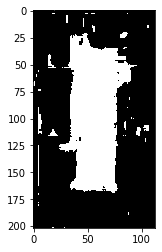

In [57]:
centroids = get_centroids(embeddings, foreground, background)
heat_map = embeddings_accuracy(embeddings, flatten_labels, labels_shape, centroids, num_classes=2)
plt.imshow(heat_map, cmap=plt.cm.gray)
plt.show()

In [58]:
save_centroids(centroid_path, centroids)
centroids_af = load_centroids(centroid_path)
assert np.array_equal(centroids_af, centroids)

### Create Video

In [7]:
model_path = 'person_model9_1_5'
centroid_path = 'Centroids/' + model_path + '_centroids' + '.pkl'
video_path = 'Videos/10fps_cropped_'+model_path+'.avi'

In [8]:
last_out_channel = 64
model = EmbeddingNet9(last_out_channel)

In [9]:
centroids = load_centroids(centroid_path)
model.load_state_dict(torch.load('Models/'+model_path+'.pt'))

<All keys matched successfully>

In [10]:
video_path = 'Videos/10fps_cropped_real_'+model_path+'.avi'
frames_step = 3

In [12]:
real_heat_maps = easy_create_real_video(model, centroids, frames_cropped, video_path, width_cropped,
                                        height_cropped, froucc=cv2.VideoWriter_fourcc('M','J','P','G'),
                                        use_gpu=True, fps=10, frames_step=frames_step, num_classes=2,
                                        ret_heat_maps=True, heatmap_path = 'heatmaps/heatmap', img_ext = '.jpg')

Generate Heat Maps: 100%|██████████| 100/100 [01:14<00:00,  1.35it/s]


Time Elapsed (get_heatmaps func) 1m 14s


<Figure size 432x288 with 0 Axes>

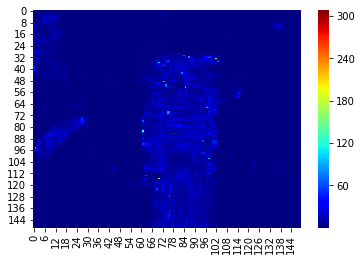

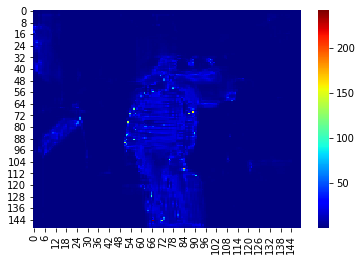

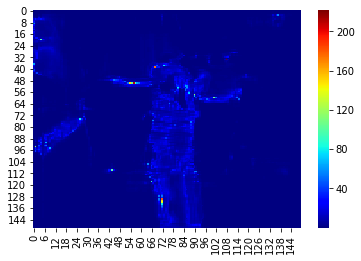

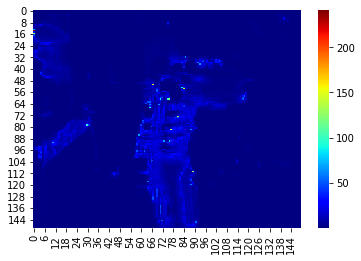

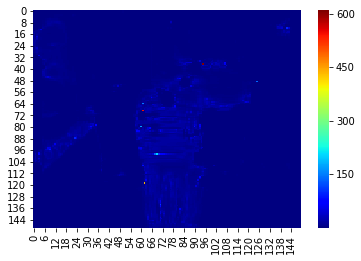

In [13]:
# print((width, height))
heat_map = sns.heatmap(real_heat_maps[0], cmap = 'jet')
plt.show()
heat_map = sns.heatmap(real_heat_maps[25], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[50], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[75], cmap = 'jet') 
plt.show()
heat_map = sns.heatmap(real_heat_maps[-1], cmap = 'jet') 
plt.show()